# Задание

<pre>
1) Попробуйте несколько методов очистки текста из приведенного ниже списка (по крайней мере, 2). Улучшило ли что-нибудь из этого качество вашей модели? Попробуйте предположить, почему. (2 балла)
    a) удаление стоп-слов
    b) удаление знаков препинания
    c) удаление мусора (лишних пробелов / специальных символов (например, @#~<> и т.д.))
    d) удаление цифр
2) Попробуйте применить стемминг (stemming) и лемматизацию (lemmatization). Что лучше улучшает качество модели?(1 балл)
3) Попробуйте разные типы векторизации и сравните модели, обученные с их помощью: (3 балла)
    a) Count vectorizer
    b) TF-IDF
    c) Word2Vec
    d) GloVe or Fast Text
4) Возьмите любую модель, с которой вы хотите провести эти эксперименты, и постарайтесь набрать как можно больше очков. (2 балла)
5) (опционально) Попробуйте проанализировать ошибки модели, чтобы найти наилучший метод оптимизации NN. (1 балл)
6) Напишите свою собственную модель и обучите ее. Отправьте submission (результаты в таблице лидеров для моделей "ручной работы" будут сравниваться отдельно). (2 балла)
</pre>

## Настройки/Гиперпараметры/Импорты

In [170]:
import pandas as pd # для удобной работы с датасетом
import numpy as np # для работы с массивами и типами данных
import torch # для работы с моделями
import re # для обработки текста
import nltk # для скачивания дополнительных пакетов nltk
from nltk.tokenize import word_tokenize # для токенизации
from nltk.corpus import stopwords # стоп-слова
from nltk.stem.snowball import EnglishStemmer # стеммер (для нормализации формы слова путём преобразования/удаления его начала и конца)
from nltk.stem import WordNetLemmatizer # лемматизатор (для нормализации формы слова с использованием морфологического анализа)

import pickle # для сохранения объектов (векторайзеров) (сохранение DataFrame в csv преобразуется массивы в ячейках в строки...)
import os.path # для проверки существования файлов (чтобы несколько раз не делать один и тот же эксперимент)

from sklearn.feature_extraction.text import CountVectorizer # для векторизации токенов Count Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer # для векторизации токенов TF-IDF
import gensim # для векторизации токенов word2vec
import torchtext # для векторизации токенов glove
# или GloVe скачивать по ссылке http://nlp.stanford.edu/data/glove.6B.zip

from sklearn.model_selection import train_test_split # для разбиения на train-test выборки

from sklearn.ensemble import GradientBoostingClassifier # ансамблевая модель для обучения

from sklearn.metrics import f1_score # для подсчёта метрики f1
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # для матрицы TP, FP, TN, FN
import matplotlib.pyplot as plt # для построения графиков

import warnings # для скрытия предупреждения от pandas
from pandas.errors import SettingWithCopyWarning # тип отключаемого warning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning) # отключение вывода warning-ов SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning) # отключение предупреждений о будущих изменениях в framework-ах

In [213]:
# num_epochs = 500 # число эпох для обучения
# device = "cpu" # девайс, на котором будет вычисление
# dtype = torch.float32 # тип данных, с которым работаем
test_size = 0.2 # размер датасета для тестирования
random_state = 42 # случайное значение для генераций


clearing_vars = ["none", "stop_words", "punctuation", "trash", "digits", "all"] # варианты очистки текста
normalization_vars = ["none", "stem", "lem"] # варианты нормализации (none - без нормализации токенов, stem - стемминг, lem - лемматизация)
vectorization_vars = ["count", "tf_idf", "word2vec", "glove"] # варианты векторизации

In [ ]:
# скачивание подмодулей для nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('words')
# nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...


True

## Описание датасета
Этот набор данных является частью коллекции новостей AG. Он содержит 4 класса новостей: world, sport, business and sci-tech.
В датасете присутствует 120 тысяч образцов данных.

Колонки:
* Class Index - содержит идентификатор класса, к которому принадлежит новость
* Title  - название новости
* Description  - текст новости

## 1) Очистка данных

        Удаление стоп слов/знаков препинания/мусора (специальных символов, ссылок...)/чисел/полная очистка/без какой-либо очистки.

In [8]:
data_train = pd.read_csv('data/train.csv') # считывание датасета для обучения
data_validation = pd.read_csv('data/test.csv', index_col="ID") # считывание датасета для валидации
data_train.head(5)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


Объединим столбцы Title и Description, так как Title не содержит явного типа новости, но может включать информацию для помощи в его определении.

In [9]:
data_train["Text"] = data_train["Title"] + ". " + data_train["Description"] # объединяем столбцы Title и Description в столбец Text
data_train.drop(["Title", "Description"], axis=1, inplace=True) # удаляем уже не нужные столбцы Title и Description

# аналогично для валидационного датасета
data_validation["Text"] = data_validation["Title"] + ". " + data_validation["Description"] # объединяем столбцы Title и Description в столбец Text
data_validation.drop(["Title", "Description"], axis=1, inplace=True) # удаляем уже не нужные столбцы Title и Description
data_train.head(5)

,Class Index,Text
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


Найдём уникальные символы в новостях для дальнейшего анализа и возможного удаления.

In [10]:
char_dict = {} # словарь уникальных символов в новостях
for text in pd.concat([data_train["Text"], data_validation["Text"]], ignore_index=True): # идём по новостям из обучающего и валидационного датасета
    for char in text: # идём по символам
        if char in char_dict: # если символ уже встречался
            char_dict[char] += 1 # увеличиваем его счётчик
        else: # иначе — добавляем в словарь
            char_dict[char] = 1
char_dict

{'W': 64203,
 'a': 1944014,
 'l': 961712,
 ' ': 4773203,
 'S': 186302,
 't': 1911892,
 '.': 367593,
 'B': 86453,
 'e': 2666737,
 'r': 1574064,
 's': 1592636,
 'C': 121647,
 'w': 318586,
 'c': 696394,
 'k': 199482,
 'I': 96032,
 'n': 1655634,
 'o': 1703779,
 'h': 840392,
 '(': 43656,
 'R': 90161,
 'u': 635740,
 ')': 43317,
 '-': 147850,
 ',': 175905,
 "'": 34291,
 'd': 852253,
 'i': 1683690,
 'g': 485213,
 '\\': 28647,
 'b': 282939,
 'f': 465345,
 'y': 380537,
 'L': 56058,
 'T': 124488,
 'm': 492636,
 'A': 168906,
 'p': 494750,
 'P': 110891,
 'v': 212281,
 'G': 53468,
 'q': 45837,
 'O': 72051,
 'E': 72433,
 'x': 55641,
 'H': 51507,
 'M': 100494,
 'U': 56662,
 'F': 70077,
 'N': 92452,
 'Y': 19959,
 '#': 50267,
 '3': 68135,
 '6': 18692,
 ';': 92671,
 '4': 20587,
 'D': 62814,
 '1': 45582,
 '7': 12269,
 '8': 11074,
 '9': 59103,
 'J': 29193,
 'j': 27616,
 'z': 26930,
 '0': 62155,
 '2': 37960,
 '"': 13788,
 'K': 31660,
 '/': 22136,
 'V': 20576,
 '$': 11632,
 '5': 21609,
 ':': 22842,
 'Z': 417

Что удаляем:
* Стоп-слова, так как они встречаются в каждой новости, поэтому не влияют на определяемый класс.
* Знаки препинания, так как они не несут особой смысловой нагрузки.
* Числа, так они также встречаются во всех новостях в виде дат или стоимостей...
* Мусорные значения, такие как лишние пробелы или специальные символы.

In [3]:
EXCLUDE_SYMBOLS_STR = u''.join(['\\', '/', '(', ')', '-', '_', '=', '*', '&', '"', "'", '#']) # специальные символы для удаления
# '$' - не удалили, так как он может нести важную информацию
regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR)) # собираем символы в формат, нужный для библиотеки re

EXCLUDE_PUNCT_STR =  u''.join(['.', ',', '?', '!', ':', ';']) # символы пунктуации в тексте
regex_punct = re.compile('[%s]' % re.escape(EXCLUDE_PUNCT_STR)) # собираем пунктуацию в формат, нужный для библиотеки re

stop_words = stopwords.words('english') # стоп-слова для английского языка

In [16]:
for var in clearing_vars:
    data_train['Tokens'] = None # создание колонки под токены
    for i in range(data_train.shape[0]): # идём по числу новостей
        text = data_train['Text'][i] # взятие текста
        text = text.lower() # приводим текст к нижнему регистру

        if var in ["trash", "all"]:
            text = re.sub(r'&lt;a.*?a&gt;', '', text) # удаление ссылок (замена на ''), начинающихся с "&lt;A" и заканчивающихся "A&gt;" (.*?-между началом и концом — любое число символов)
            text = text.replace(".com", "") # удаление окончаний ссылок (неполных, у которых есть только .com)
            text = regex_symb.sub(' ', text) # удаление специальных символов
        if var in ["punctuation", "all"]:
            text = regex_punct.sub('', text) # удаление пунктуации
        if var in ["digits", "all"]:
            text = re.sub(r'\d+', '', text) # удаление чисел

        tokens = [word.strip() for word in word_tokenize(text)] # токенизация текста (разбиение на отдельные слова + удаляем пробелы)

        if var in ["stop_words", "all"]:
            tokens = [word for word in tokens if word not in stop_words] # удаление стоп-слов
        data_train['Tokens'][i] = tokens # обновление в датасете (теперь вместо текста идут токены)
    data_train.to_pickle(f"data/preprocessed/data_train_{var}.pkl") # сохранение предобработанных токенов с текстом новости

In [17]:
data_train # вывод полностью очищенных токенов

,Class Index,Text,Tokens
0,3,Wall St. Bears Claw Back Into the Black (Reute...,"[wall, st, bears, claw, back, black, reuters, ..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,"[carlyle, looks, toward, commercial, aerospace..."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...,"[oil, economy, cloud, stocks, outlook, reuters..."
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,"[iraq, halts, oil, exports, main, southern, pi..."
4,3,"Oil prices soar to all-time record, posing new...","[oil, prices, soar, time, record, posing, new,..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,"[pakistan, musharraf, says, quit, army, chief,..."
119996,2,Renteria signing a top-shelf deal. Red Sox gen...,"[renteria, signing, top, shelf, deal, red, sox..."
119997,2,Saban not going to Dolphins yet. The Miami Dol...,"[saban, going, dolphins, yet, miami, dolphins,..."
119998,2,Today's NFL games. PITTSBURGH at NY GIANTS Tim...,"[today, nfl, games, pittsburgh, ny, giants, ti..."


## 2) Нормализация

        Stemming/Lemmatization/отсутствие нормализации.

In [20]:
stemmer = EnglishStemmer() # стеммер
lemmatizer = WordNetLemmatizer() # лемматизатор

In [21]:
for var1 in clearing_vars: # идём по вариантам очистки текста
    for var2 in normalization_vars: # идём по вариантам нормализации
        data_train = pd.read_pickle(f"data/preprocessed/data_train_{var1}.pkl") # открываем сохраннённый предобработанный датасет (текст + токены)

        if var2 == "stem": # если нормализация - стемминг
            for i in range(data_train.shape[0]): # идём по числу новостей
                stemmed_tokens = [stemmer.stem(word) for word in data_train["Tokens"][i]] # используем стеммер на токенах-словах
                data_train["Tokens"][i] = stemmed_tokens # заменяем токены
        elif var2 == "lem": # если нормализация - лемматизация
            for i in range(data_train.shape[0]): # идём по числу новостей
                lemmatized_tokens = [lemmatizer.lemmatize(word) for word in data_train["Tokens"][i]] # используем лемматизатор на токенах-словах
                data_train["Tokens"][i] = lemmatized_tokens # заменяем токены

        data_train.to_pickle(f"data/normalized/data_train_{var1}_{var2}.pkl") # сохранение нормализованных токенов

In [22]:
data_train # вывод: полная очистка текста + лемматизация

,Class Index,Text,Tokens
0,3,Wall St. Bears Claw Back Into the Black (Reute...,"[wall, st, bear, claw, back, black, reuters, r..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,"[carlyle, look, toward, commercial, aerospace,..."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...,"[oil, economy, cloud, stock, outlook, reuters,..."
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,"[iraq, halt, oil, export, main, southern, pipe..."
4,3,"Oil prices soar to all-time record, posing new...","[oil, price, soar, time, record, posing, new, ..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,"[pakistan, musharraf, say, quit, army, chief, ..."
119996,2,Renteria signing a top-shelf deal. Red Sox gen...,"[renteria, signing, top, shelf, deal, red, sox..."
119997,2,Saban not going to Dolphins yet. The Miami Dol...,"[saban, going, dolphin, yet, miami, dolphin, p..."
119998,2,Today's NFL games. PITTSBURGH at NY GIANTS Tim...,"[today, nfl, game, pittsburgh, ny, giant, time..."


### old

        Stemming

Stemming для нормализации формы слова преобразовывает (удаляет) его начало (приставку) и конец (суффикс/окончание), приводя его тем самым к "корневому" виду (root/base word).

In [ ]:
# stemmer = EnglishStemmer() # стеммер

# data_train_stemmed = data_train.copy() # копируем данные для стемминга

# for i in range(data_train.shape[0]): # идём по числу новостей
#     stemmed_tokens = [stemmer.stem(word) for word in data_train["Tokens"][i]] # используем стеммер на токенах-словах
#     data_train_stemmed["Tokens"][i] = stemmed_tokens # заменяем токены
# data_train_stemmed

,Class Index,Text,Tokens
0,3,Wall St. Bears Claw Back Into the Black (Reute...,"[wall, st, bear, claw, back, black, reuter, re..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,"[carlyl, look, toward, commerci, aerospac, reu..."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...,"[oil, economi, cloud, stock, outlook, reuter, ..."
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,"[iraq, halt, oil, export, main, southern, pipe..."
4,3,"Oil prices soar to all-time record, posing new...","[oil, price, soar, time, record, pose, new, me..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,"[pakistan, musharraf, say, quit, armi, chief, ..."
119996,2,Renteria signing a top-shelf deal. Red Sox gen...,"[renteria, sign, top, shelf, deal, red, sox, g..."
119997,2,Saban not going to Dolphins yet. The Miami Dol...,"[saban, go, dolphin, yet, miami, dolphin, put,..."
119998,2,Today's NFL games. PITTSBURGH at NY GIANTS Tim...,"[today, nfl, game, pittsburgh, ny, giant, time..."


        Lemmatization

Lemmatization для нормализации формы слова использует словарь и морфологический анализ, чтобы в итоге привести слово к его канонической форме – лемме. Кроме того, лемматизация привносит контекст в слова, связывает слова со схожим значением в одно слово (например - лемма для слова "better" - "good", если указать его как прилагательное).

Плюсы Lemmatization:
- увеличивает точность при анализе текста (Lemmatization helps in improving the accuracy of text analysis by reducing words to their base or dictionary form. This makes it easier to identify and analyze words that have similar meanings.)
- уменьшает размер данных (Since lemmatization reduces words to their base form, it helps in reducing the data size of the text, which makes it easier to handle large datasets.)
- улучшает результаты поиска (Lemmatization helps in retrieving better search results since it reduces different forms of a word to a common base form, making it easier to match different forms of a word in the text.)
- полезна для извлечения признаков (Lemmatization can be useful in feature extraction tasks, where the aim is to extract meaningful features from text for machine learning tasks.)
  
Минусы Lemmatization:
- необходимо предварительное знание используемого языка (Lemmatization requires prior knowledge of the language and the rules governing the formation of words. If the rules for a specific language are not available, then the accuracy of the lemmatizer may be affected.)
- времязатратный алгоритм (Lemmatization can be time-consuming since it involves parsing the text and performing a lookup in a dictionary or a database of word forms.)
- может привести к двусмысленности (Lemmatization may lead to ambiguity, as a single word may have multiple meanings depending on the context in which it is used. In such cases, the lemmatizer may not be able to determine the correct meaning of the word.)

In [ ]:
# lemmatizer = WordNetLemmatizer() # лемматизатор
# data_train_lemmatizer = data_train.copy() # копируем данные для лемматизации

# for i in range(data_train.shape[0]): # идём по числу новостей
#     lemmatized_tokens = [lemmatizer.lemmatize(word) for word in data_train["Tokens"][i]] # используем лемматизатор на токенах-словах
#     data_train_lemmatizer["Tokens"][i] = lemmatized_tokens # заменяем токены
# data_train_lemmatizer

,Class Index,Text,Tokens
0,3,Wall St. Bears Claw Back Into the Black (Reute...,"[wall, st, bear, claw, back, black, reuters, r..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,"[carlyle, look, toward, commercial, aerospace,..."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...,"[oil, economy, cloud, stock, outlook, reuters,..."
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,"[iraq, halt, oil, export, main, southern, pipe..."
4,3,"Oil prices soar to all-time record, posing new...","[oil, price, soar, time, record, posing, new, ..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,"[pakistan, musharraf, say, quit, army, chief, ..."
119996,2,Renteria signing a top-shelf deal. Red Sox gen...,"[renteria, signing, top, shelf, deal, red, sox..."
119997,2,Saban not going to Dolphins yet. The Miami Dol...,"[saban, going, dolphin, yet, miami, dolphin, p..."
119998,2,Today's NFL games. PITTSBURGH at NY GIANTS Tim...,"[today, nfl, game, pittsburgh, ny, giant, time..."


In [ ]:
# сохранение посчитанных данных в pickle формате для сохранения колонки Tokens в виде списка (в csv он преобразуется в строку...)
# data_train.to_pickle("data/data_train_1.pkl")
# data_train_stemmed.to_pickle("data/data_train_stemmed_1.pkl")
# data_train_lemmatizer.to_pickle("data/data_train_lemmatizer_1.pkl")
# data_validation.to_pickle("data/data_validation_1.pkl")

## 3) Векторизация

        Count Vectorizer/TF-IDF/Word2Vec/GloVe.

In [4]:
def dummy(tokens): # функция-заглушка для пропуска стадий препроцессинга и токенизации при векторизации (CountVectorizer и TfidfVectorizer)
   return tokens

In [ ]:
for var1 in clearing_vars: # идём по вариантам препроцессинга
    for var2 in normalization_vars: # идём по вариантам нормализации
        data_train = pd.read_pickle(f"data/normalized/data_train_{var1}_{var2}.pkl") # открываем сохраннённый нормализованный датасет (текст + нормализованные токены)
        for var3 in vectorization_vars: # идём по вариантам векторизации
            print(f"vectorizing {var1} {var2} {var3}...")
            if var3 == "count": # векторизация Count Vectorizer
                vectorizer = CountVectorizer(tokenizer=dummy, preprocessor=dummy, max_df=0.5, min_df=25, max_features=1000, dtype=np.int8) # объект count vectorizer
                # max_df - игнорируем токены, что встречаются в 50% переданных новостей
                # min_df - игнорируем токены, что встретились менее 25 раз
                # max_features - максимальный размер словаря, если не прокинуть — то он равен числу уникальных токенов (1000 слов, иначе подсчёт будет идти~6часов)
                # dtype=np.int8 - для уменьшения потребляемой памяти, так как максимальное число встреченных одинаковых токенов в одной новости не более 48 (подсчитано на различных тестах)

                vectors = vectorizer.fit_transform(data_train['Tokens']).toarray() # векторизируем, toarray() - показать матрицу
            
            elif var3 == "tf_idf": # векторизация TF-IDF
                # vectorizer = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy, max_df=0.5, min_df=25, dtype=np.float32) # векторизируем, toarray() - показать матрицу
                vectorizer = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy, max_df=0.5, min_df=25, max_features=1000, dtype=np.float32) # векторизируем, toarray() - показать матрицу
                # max_df - игнорируем токены, что встречаются в 50% переданных новостей
                # min_df - игнорируем токены, что встретились менее 25 раз
                # max_features - максимальный размер словаря, если не прокинуть — то он равен числу уникальных токенов (1000 слов, иначе подсчёт будет идти~6часов)
                # dtype=np.float32 - для уменьшения потребляемой памяти

                vectors = vectorizer.fit_transform(data_train['Tokens']).toarray() # векторизируем, toarray() - показать матрицу
                
            elif var3 == "word2vec": # векторизация Word2Vec
                vectorizer = gensim.models.Word2Vec(sentences=data_train["Tokens"], vector_size=100, window=5, min_count=1, sg=0, alpha=0.001, seed=random_state, epochs=10) 
                # sentences - список списков токенов
                # vector_size - размерность вектора слов
                # window - максимальная дистанция между текущим и предсказанным словом у одной новости
                # min_count - игнорировать слова, у которых частота ниже заданного значения
                # sg - использовать skip-gram (=1) или CBOW (!=1)
                # alpha - начальный learning rate
                # seed - значения для рандомизации
                # epochs - число итераций по корпусу новостей

                vectors = np.zeros((data_train.shape[0], vectorizer.vector_size), dtype=np.float32) # пространство векторов для новостей размера: число новостей * размер вектора для одного токена в векторайзере
                for i in range(data_train.shape[0]): # идём по новостям
                    for token in data_train["Tokens"][i]: # идём по токенам новости
                        if token in vectorizer.wv: # проверка, что такой токен есть в словаре векторайзера
                            vectors[i] += vectorizer.wv[token] # складываем значения векторов-токенов
                    vectors[i] = vectors[i] / len(data_train["Tokens"][i]) # усредняем по числу токенов в новости
            
            elif var3 == "glove": # векторизация GloVe
                # создание словаря встреченных в корпусе токенов
                vectorizer = {} # создаём словарь для уникальных токенов, встреченных в корпусе
                for tokens in data_train["Tokens"]: # идём по спискам токенов новостей
                    for token in tokens: # идём по каждому токену в новости
                        if token not in vectorizer.keys(): # если токен до этого не встречался — добавляем его как ключ в словарь
                            vectorizer[token] = None

                # заполнение этого словаря значениями GloVe векторов
                with open("data/glove.6B.100d.txt", encoding="utf8") as f: # открываем файл словаря GloVe
                    for line in f: # идём построчно
                        word, *vector = line.split() # ключ и соответствующий ему вектор из GloVe
                        if word in vectorizer.keys(): # если ключ в GloVe словаре был нами встречен ранее в корпусе, то запоминаем его вектор
                            vectorizer[word] = np.array(vector, dtype=np.float32)

                # суммирование GloVe векторов токенов новостей
                vectors = np.zeros((data_train.shape[0], 100), dtype=np.float32) # пространство векторов для новостей размера: число новостей * размер GloVe вектора для одного токена
                for i in range(data_train.shape[0]): # идём по новостям
                    processed_count = 0 # счётчик обработанных токенов у новости
                    for token in data_train["Tokens"][i]: # идём по токенам новости
                        if vectorizer[token] is not None: # проверяем наличие вектора для токена
                            vectors[i] += vectorizer[token] # складываем значения векторов-токенов
                            processed_count += 1 # увеличиваем счётчик обработанных токенов (тех, для которых есть GloVe вектор)
                    vectors[i] = vectors[i] / processed_count # усредняем по числу обработанных токенов в новости

            with open(f"data/vectorized/data_train_{var1}_{var2}_{var3}.pkl", 'wb') as f: # открытие файла для записи (b - бинарной)
                pickle.dump(vectors, f) # сохранение векторов
            with open(f"vectorizers/vectorizer_{var1}_{var2}_{var3}.pkl", 'wb') as f: # открытие файла для записи (b - бинарной)
                pickle.dump(vectorizer, f) # сохранение векторайзеров
            print(f"done {var1} {var2} {var3}")

### skip

        Частота встречи различного числа токенов:

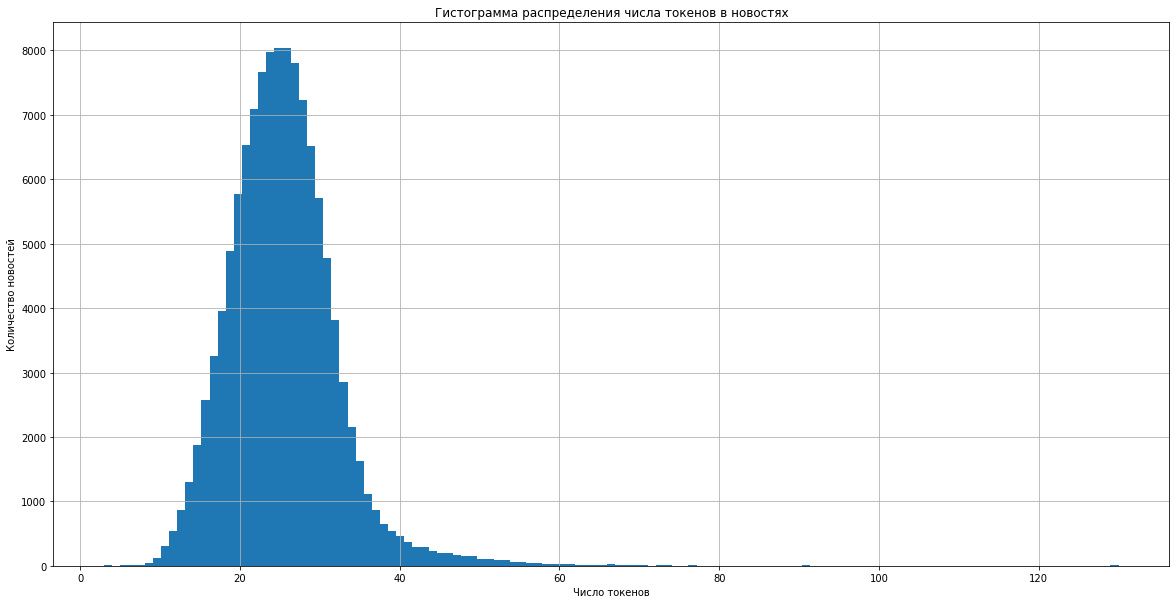

In [ ]:
tokens_size = [len(tokens) for tokens in data_train["Tokens"]] # массив числа токенов у новостей

plt.figure(figsize=(20, 10)) # размер фигуры
plt.hist(tokens_size, bins=125) # построение гистограммы
plt.title("Гистограмма распределения числа токенов в новостях") # название графика
plt.xlabel('Число токенов') # подпись по оси x
plt.ylabel('Количество новостей') # подпись по оси y
plt.grid(True) # добавление сетки на график
plt.show() # вывод графика

        Анализ числа уникальных токенов:

Без стемминга/лемматизации:

In [ ]:
# unique_tokens = dict() # словарь количества встреченных токенов
# for i in range(data_train.shape[0]): # идём по новостям
#     for j in range(len(data_train["Tokens"][i])): # идём по токенам новости
#         if data_train["Tokens"][i][j] not in unique_tokens: # если токен встречается в первый раз, то добавляем его в словарь, как встреченный один раз
#             unique_tokens[data_train["Tokens"][i][j]] = 1
#         else: # иначе — увеличиваем его счётчик
#             unique_tokens[data_train["Tokens"][i][j]] += 1
# len(f"Число уникальных токенов: {unique_tokens}") # вывод числа уникальных токенов

61662

In [ ]:
# sorted(unique_tokens.items(), key=lambda x:-x[1])

[('new', 21425),
 ('said', 20267),
 ('reuters', 19340),
 ('ap', 16277),
 ('us', 13334),
 ('gt', 13239),
 ('lt', 13183),
 ('$', 10976),
 ('two', 10225),
 ('first', 9802),
 ('year', 9771),
 ('quot', 9596),
 ('world', 8634),
 ('u', 8616),
 ('one', 8108),
 ('company', 7656),
 ('monday', 7616),
 ('oil', 7564),
 ('wednesday', 7530),
 ('tuesday', 7453),
 ('thursday', 7346),
 ('friday', 6868),
 ('inc', 6853),
 ('b', 6600),
 ('last', 6548),
 ('iraq', 6335),
 ('york', 6268),
 ('yesterday', 6099),
 ('three', 6034),
 ('president', 5994),
 ('microsoft', 5936),
 ('million', 5812),
 ('game', 5774),
 ('week', 5654),
 ('time', 5498),
 ('says', 5345),
 ('corp', 5170),
 ('united', 5129),
 ('stocks', 4952),
 ('sunday', 4930),
 ('prices', 4907),
 ('government', 4862),
 ('could', 4854),
 ('would', 4821),
 ('security', 4790),
 ('n', 4766),
 ('years', 4721),
 ('group', 4714),
 ('today', 4708),
 ('people', 4676),
 ('may', 4586),
 ('second', 4542),
 ('afp', 4529),
 ('percent', 4515),
 ('back', 4492),
 ('softwar

In [ ]:
# data_train

,Class Index,Text,Tokens
0,3,Wall St. Bears Claw Back Into the Black (Reute...,"[wall, st, bears, claw, back, black, reuters, ..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,"[carlyle, looks, toward, commercial, aerospace..."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...,"[oil, economy, cloud, stocks, outlook, reuters..."
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,"[iraq, halts, oil, exports, main, southern, pi..."
4,3,"Oil prices soar to all-time record, posing new...","[oil, prices, soar, time, record, posing, new,..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,"[pakistan, musharraf, says, quit, army, chief,..."
119996,2,Renteria signing a top-shelf deal. Red Sox gen...,"[renteria, signing, top, shelf, deal, red, sox..."
119997,2,Saban not going to Dolphins yet. The Miami Dol...,"[saban, going, dolphins, yet, miami, dolphins,..."
119998,2,Today's NFL games. PITTSBURGH at NY GIANTS Tim...,"[today, nfl, games, pittsburgh, ny, giants, ti..."


In [ ]:
# unique_tokens_freq = dict()
# for i in range(data_train.shape[0]): # идём по новостям
#     for j in range(len(data_train["Tokens"][i])): # идём по токенам новости
#         if data_train["Tokens"][i][j] not in unique_tokens_freq: # если токен встречается в первый раз, то добавляем его в словарь, как встреченный один раз
#             unique_tokens_freq[data_train["Tokens"][i][j]] = [0,0,0,0]
#         unique_tokens_freq[data_train["Tokens"][i][j]][data_train["Class Index"][i]-1] += 1

In [ ]:
# unique_tokens_freq

{'wall': [149, 36, 1103, 136],
 'st': [141, 1060, 203, 283],
 'bears': [20, 298, 18, 65],
 'claw': [0, 4, 10, 3],
 'back': [698, 2000, 978, 816],
 'black': [233, 130, 296, 131],
 'reuters': [5423, 1681, 8717, 3519],
 'short': [142, 291, 276, 189],
 'sellers': [2, 0, 13, 32],
 'street': [272, 33, 1143, 170],
 'dwindling': [5, 3, 7, 17],
 'band': [42, 18, 30, 122],
 'ultra': [11, 3, 16, 51],
 'cynics': [0, 3, 2, 0],
 'seeing': [20, 44, 25, 47],
 'green': [198, 486, 79, 87],
 'carlyle': [0, 0, 16, 0],
 'looks': [62, 172, 161, 206],
 'toward': [288, 125, 202, 145],
 'commercial': [62, 22, 185, 237],
 'aerospace': [6, 0, 85, 37],
 'private': [109, 49, 316, 251],
 'investment': [38, 20, 691, 79],
 'firm': [152, 61, 1000, 572],
 'group': [1330, 387, 2028, 969],
 'reputation': [22, 49, 22, 24],
 'making': [211, 271, 299, 481],
 'well': [207, 346, 274, 436],
 'timed': [8, 4, 3, 5],
 'occasionally': [3, 4, 2, 7],
 'controversial': [171, 84, 79, 98],
 'plays': [44, 186, 14, 54],
 'defense': [461,

Со стеммингом:

In [ ]:
# unique_tokens_stem = dict() # словарь количества встреченных токенов
# for i in range(data_train_stemmed.shape[0]): # идём по новостям
#     for j in range(len(data_train_stemmed["Tokens"][i])): # идём по токенам новости
#         if data_train_stemmed["Tokens"][i][j] not in unique_tokens_stem: # если токен встречается в первый раз, то добавляем его в словарь, как встреченный один раз
#             unique_tokens_stem[data_train_stemmed["Tokens"][i][j]] = 1
#         else: # иначе — увеличиваем его счётчик
#             unique_tokens_stem[data_train_stemmed["Tokens"][i][j]] += 1
# len(f"Число уникальных токенов при использовании stemming: {unique_tokens_stem}") # вывод числа уникальных токенов

42857

С лемматизацией:

In [ ]:
# unique_tokens_lem = dict() # словарь количества встреченных токенов
# for i in range(data_train_lemmatizer.shape[0]): # идём по новостям
#     for j in range(len(data_train_lemmatizer["Tokens"][i])): # идём по токенам новости
#         if data_train_lemmatizer["Tokens"][i][j] not in unique_tokens_lem: # если токен встречается в первый раз, то добавляем его в словарь, как встреченный один раз
#             unique_tokens_lem[data_train_lemmatizer["Tokens"][i][j]] = 1
#         else: # иначе — увеличиваем его счётчик
#             unique_tokens_lem[data_train_lemmatizer["Tokens"][i][j]] += 1
# len(f"Число уникальных токенов при использовании lemmatization: {unique_tokens_lem}") # вывод числа уникальных токенов

54986

### a) Count vectorizer

Count vectorizer преобразует каждую новость (список токенов) в вектор размера используемого словаря (=число уникальных токенов в корпусе). В векторе на $i$-ой позиции идёт число вхождений токена под номером $i$ в новость.

In [7]:
count_vectorizer = CountVectorizer(tokenizer=dummy, preprocessor=dummy, max_df=0.5, min_df=25, dtype=np.int16)
# max_df - игнорируем токены, что встречаются в 50% переданных новостей
# min_df - игнорируем токены, что встретились менее 25 раз
# max_features - максимальный размер словаря, если не прокинуть — то он равен числу уникальных токенов
# dtype=np.int16 - для уменьшения потребляемой памяти, так как максимальное число встреченных токенов 21425 у "new"

vectors = count_vectorizer.fit_transform(data_train['Tokens']).toarray() # векторизируем, toarray() - показать матрицу

pd.DataFrame(data=vectors, columns=count_vectorizer.get_feature_names_out()) # матрица для наглядного вывода получившихся векторов новостей

c:\Users\User\anaconda3\envs\gpu\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,$,aa,aapl,aaron,ab,abandon,abandoned,abandoning,abandons,abbas,...,zero,ziff,zimbabwe,zimbabwean,zombie,zone,zoo,zook,zurich,zvonareva
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
119996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
119997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
119998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### b) TF-IDF (Term Frequency-Inverse Document Frequency)

TF-IDF - способ векторизации текста, отражающий важность слова (токена) в документе, а не только частоту его появления. Он означает «частота термина — обратная частота документа» и придает вес словам, которые в конечном счете являются более значимыми во всем корпусе слов — словам, которые не появляются невероятно часто, а также словам, которые не являются чрезвычайно редкими.

TF-IDF - статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален частоте употребления этого слова в документе и обратно пропорционален частоте употребления слова во всех документах коллекции.

Пример: если документ содержит 100 слов, и слово «заяц» встречается в нём 3 раза, то частота слова (TF) для слова «заяц» в документе будет 0,03 (3/100). Вычислим IDF как десятичный логарифм отношения количества всех документов к количеству документов, содержащих слово «заяц». Таким образом, если «заяц» содержится в 1000 документах из 10 000 000 документов, то IDF будет равной: log(10 000 000/1000) = 4. Для расчета окончательного значения веса слова необходимо TF умножить на IDF. В данном примере, TF-IDF вес для слова «заяц» в выбранном документе будет равен: 0,03 × 4 = 0,12.

In [10]:
tf_idf_vectorizer = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy, max_df=0.5, min_df=25, dtype=np.float32) # векторизируем, toarray() - показать матрицу
# max_df - игнорируем токены, что встречаются в 50% переданных новостей
# min_df - игнорируем токены, что встретились менее 25 раз
# max_features - максимальный размер словаря, если не прокинуть — то он равен числу уникальных токенов
# dtype=np.float32 - для уменьшения потребляемой памяти

vectors = tf_idf_vectorizer.fit_transform(data_train['Tokens']).toarray() # векторизируем, toarray() - показать матрицу

pd.DataFrame(data=vectors, columns=tf_idf_vectorizer.get_feature_names_out()) # матрица для наглядного вывода получившихся векторов новостей

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,$,aa,aapl,aaron,ab,abandon,abandoned,abandoning,abandons,abbas,...,zero,ziff,zimbabwe,zimbabwean,zombie,zone,zoo,zook,zurich,zvonareva
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119996,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119997,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119998,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### c) Word2Vec

Работа Word2Vec осуществляется следующим образом: Word2Vec принимает большой текстовый корпус в качестве входных данных и сопоставляет каждому слову вектор, выдавая координаты слов на выходе. Сначала он генерирует словарь корпуса, а затем вычисляет векторное представление слов, «обучаясь» на входных текстах. Векторное представление основывается на контекстной близости: слова, встречающиеся в тексте рядом с одинаковыми словами (а следовательно, имеющие схожий смысл), будут иметь близкие (по косинусному расстоянию) векторы. Полученные векторные представления слов могут быть использованы для обработки естественного языка и машинного обучения.

In [47]:
word2vec_vectorizer = gensim.models.Word2Vec(sentences=data_train["Tokens"], vector_size=100, window=5, min_count=1, sg=0, alpha=0.0001, seed=random_state, epochs=10) 
# sentences - список списков токенов
# vector_size - размерность вектора слов
# window - максимальная дистанция между текущим и предсказанным словом у одной новости
# min_count - игнорировать слова, у которых частота ниже заданного значения
# sg - использовать skip-gram (=1) или CBOW (!=1)
# alpha - начальный learning rate
# seed - значения для рандомизации
# epochs - число итераций по корпусу новостей

In [101]:
test = data_train.iloc[:200] # бросто взяли срез датасета для ускорения работы
test

,Class Index,Text,Tokens
0,3,Wall St. Bears Claw Back Into the Black (Reute...,"[wall, st., bears, claw, back, into, the, blac..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,"[carlyle, looks, toward, commercial, aerospace..."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...,"[oil, and, economy, cloud, stocks, ', outlook,..."
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,"[iraq, halts, oil, exports, from, main, southe..."
4,3,"Oil prices soar to all-time record, posing new...","[oil, prices, soar, to, all-time, record, ,, p..."
...,...,...,...
195,4,Britons embrace digital lifestyle. People in t...,"[britons, embrace, digital, lifestyle, ., peop..."
196,4,PlayStation potential to learning. The PlaySta...,"[playstation, potential, to, learning, ., the,..."
197,4,'Invisible' technology for Olympics. Getting t...,"['invisible, ', technology, for, olympics, ., ..."
198,4,Satellite boosts Olympic security. An enhanced...,"[satellite, boosts, olympic, security, ., an, ..."


In [102]:
# test["Tokens"].aaply(lambda tokens: np.mean([vectorizer.wv[token] for token in tokens if token in vectorizer.wv]))
vectors = np.zeros((test.shape[0], word2vec_vectorizer.vector_size)) # пространство векторов для новостей размера: число новостей * размер вектора для одного токена в векторайзере
for i in range(test.shape[0]):
    for token in test["Tokens"][i]: # идём по токенам
        if token in word2vec_vectorizer.wv: # проверка, что такой токен есть в словаре векторайзера
            vectors[i] += word2vec_vectorizer.wv[token] # складываем значения векторов-токенов
    vectors[i] = vectors[i] / len(test["Tokens"][i]) # усредняем по числу токенов в новости
vectors

array([[ 0.17992499, -0.0169375 , -0.12761697, ...,  0.15541135,
        -0.27902459, -0.07334933],
       [ 0.13002597, -0.02201059, -0.11123795, ...,  0.1231101 ,
        -0.2479252 , -0.08640362],
       [ 0.13520837, -0.02376273, -0.1115632 , ...,  0.12320224,
        -0.24564293, -0.07654763],
       ...,
       [ 0.07618485, -0.02772058, -0.10396783, ...,  0.10449982,
        -0.25025209, -0.12642487],
       [ 0.06109259, -0.01277423, -0.07880818, ...,  0.08184914,
        -0.18040722, -0.09232863],
       [ 0.05578228, -0.00994823, -0.06726768, ...,  0.06905822,
        -0.15119888, -0.07496944]])

In [ ]:
# word2vec_vectorizer.wv["new"] # вектор слова "new"
# word2vec_vectorizer.wv.similarity("new", "funny") # похожесть слов

### d) GloVe

GloVe имеет заранее определённые векторы плотности (dense vectors) примерно для 6 миллиардов слов английской литературы, а также для многих других символов общего использования, таких как запятая, фигурные скобки и точки с запятой. 

Идея векторизации с использованием Glove: смотреть токены новости и суммировать соответствующие им GloVe вектора (dense vectors), можно с нормализацией (делением на общее число токенов в новости).

In [ ]:
# создание словаря встреченных в корпусе токенов
vocabulary = {} # создаём словарь для уникальных токенов, встреченных в корпусе
for tokens in data_train["Tokens"]: # идём по спискам токенов новостей
    for token in tokens: # идём по каждому токену в новости
        if token not in vocabulary.keys(): # если токен до этого не встречался — добавляем его как ключ в словарь
            vocabulary[token] = None

In [119]:
# заполнение этого словаря значениями GloVe векторов
with open("data/glove.6B.100d.txt", encoding="utf8") as f: # открываем файл словаря GloVe
    for line in f: # идём построчно
        word, *vector = line.split() # ключ и соответствующий ему вектор из GloVe
        if word in vocabulary.keys(): # если ключ в GloVe словаре был нами встречен ранее в корпусе, то запоминаем его вектор
            vocabulary[word] = np.array(vector, dtype=np.float32)

In [131]:
vectors = np.zeros((data_train.shape[0], 100)) # пространство векторов для новостей размера: число новостей * размер GloVe вектора для одного токена
for i in range(data_train.shape[0]): # идём по новостям
    processed_count = 0 # счётчик обработанных токенов у новости
    for token in data_train["Tokens"][i]: # идём по токенам новости
        if vocabulary[token] is not None: # проверяем наличие вектора для токена
            vectors[i] += vocabulary[token] # складываем значения векторов-токенов
            processed_count += 1 # увеличиваем счётчик обработанных токенов (тех, для которых есть GloVe вектор)
    vectors[i] = vectors[i] / processed_count # усредняем по числу обработанных токенов в новости

In [133]:
vectors

array([[-0.08904876,  0.1418376 ,  0.3166672 , ..., -0.3066156 ,
         0.5017708 ,  0.01838884],
       [-0.03992283,  0.06358825,  0.22847757, ..., -0.3479877 ,
         0.6065146 ,  0.18952758],
       [-0.10287571,  0.3085236 ,  0.471442  , ..., -0.33614692,
         0.61256715,  0.109835  ],
       ...,
       [-0.00391325, -0.07915681,  0.40560688, ..., -0.11582925,
         0.5820763 ,  0.10577753],
       [-0.0373301 ,  0.10784906,  0.57090924, ..., -0.09486366,
         0.50229452,  0.12862547],
       [ 0.13958712, -0.01064349,  0.37617046, ..., -0.09695654,
         0.26704538, -0.01655683]])

In [ ]:
# import torchtext

# # при первом запуске будет скачиваться файл размера ~823MB
# glove = torchtext.vocab.GloVe(name="6B", # trained on Wikipedia 2014 corpus
#                               dim=100)    # размер вектора кодирования (embedding size) = 100

# torch.cosine_similarity(glove['cat'].unsqueeze(0), glove['dog'].unsqueeze(0)) # подсчёт схожести векторов

## 4) Обучение моделей (Multiclass Classification)

        В качестве модели для обучения был выбран Gradient Boosting Classifier, так как он хорошо работает с табличными данными и задачей multi-class classification.
Gradient Boosting Classifier - это техника машинного обучения для задач классификации и регрессии, которая строит модель предсказания в форме ансамбля (бустинг) слабых предсказывающих моделей, обычно деревьев решений. Обучение моделей бустинг ансамбля проводится последовательно, а не параллельно (каждый следующий "слой" ансамбля старается уменьшить ошибку текущего). Выходным данным отдельных деревьев присваиваются веса. Затем неправильным классификациям из первого дерева решений присваивается больший вес, после чего данные передаются в следующее дерево.

In [ ]:
targets = pd.read_csv("data/train.csv")["Class Index"] # взятие таргетов из начального датасета
for var1 in clearing_vars: # идём по вариантам препроцессинга
    for var2 in normalization_vars: # идём по вариантам нормализации
        for var3 in vectorization_vars: # идём по вариантам векторизации
            if os.path.exists(f"preds/pred_{var1}_{var2}_{var3}.pkl"): # если уже делали предсказание на данных, то пропускаем 
                print(f"skip {var1} {var2} {var3}")
                continue # переходим на следующую итерацию цикла

            try: # на случай, если векторизация ещё не обработала данные для эксперимента {var1} {var2} {var3}
                with open(f"data/vectorized/data_train_{var1}_{var2}_{var3}.pkl", 'rb') as f: # чтение файла
                    features = pickle.load(f) # загрузка получившихся векторов
            except:
                print(f"no file {var1} {var2} {var3}")
                continue # переходим на следующую итерацию цикла
            
            print(f"modeling {var1} {var2} {var3}")

            X_train, X_test, Y_train, Y_test = train_test_split(features, targets, test_size=test_size, random_state=random_state) # делаем train-test split
            model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=random_state).fit(X_train, Y_train) # обучаем модель
            Y_pred = model.predict(X_test) # делаем предсказание

            with open(f"preds/pred_{var1}_{var2}_{var3}.pkl", 'wb') as f: # открытие файла для записи (b - бинарной)
                pickle.dump(Y_pred, f) # сохранение предсказаний
            with open(f"models/model_{var1}_{var2}_{var3}.pkl", 'wb') as f: # открытие файла для записи (b - бинарной)
                pickle.dump(model, f) # сохранение модели

            print(f"done {var1} {var2} {var3}")

with open(f"preds/true.pkl", 'wb') as f: # открытие файла для записи (b - бинарной)
    pickle.dump(Y_test, f) # сохранение ожидаемых предсказаний

### Подсчёт F1 метрики

In [175]:
scores = {} # словарь с результатами всех экспериментов вида
# {
#   вариант очистки: {
#       вариант нормализации: {
#            вариант векторизации: [f1 score, предсказанные классы]
#       }
#   }
# }
with open(f"preds/true.pkl", 'rb') as f: # чтение файла
    Y_test = pickle.load(f) # загрузка ожидаемых предсказаний

for var1 in clearing_vars: # идём по вариантам препроцессинга
    if var1 not in scores.keys(): # добавляем вариант в словарь, если его там не было
        scores[var1] = {} # его значение — пока пустой словарь
    for var2 in normalization_vars: # идём по вариантам нормализации
        if var2 not in scores[var1].keys(): # добавляем вариант в словарь, если его там не было
            scores[var1][var2] = {} # его значение — пока пустой словарь
        for var3 in vectorization_vars: # идём по вариантам векторизации
            with open(f"preds/pred_{var1}_{var2}_{var3}.pkl", 'rb') as f: # чтение файла
                Y_pred = pickle.load(f) # загрузка получившихся векторов
            if var3 not in scores[var1][var2].keys(): # добавляем вариант в словарь, если его там не было
                scores[var1][var2][var3] = [f1_score(Y_test, Y_pred, average="micro"), Y_pred.copy()] # считаем F1 score (average="micro" считает средний F1 score для всех классов - то есть глобально, подсчитывая общее количество TP, FN, FP)

In [207]:
scores_ = [] # для перевода f1 score в сортируемый массив
for var1 in clearing_vars: # идём по вариантам препроцессинга
    for var2 in normalization_vars: # идём по вариантам нормализации
        for var3 in vectorization_vars: # идём по вариантам векторизации
            scores_.append([scores[var1][var2][var3][0], var1, var2, var3])
scores_.sort(key = lambda x: -x[0]) # сортируем экспериментыв порядке уменьшения f1 score

scores_ = pd.DataFrame(scores_, columns=["F1 score", "Очистка", "Нормализация", "Векторизация"]) # перевод экспериментов в DataFrame
with pd.option_context('display.max_rows', None, # без лимита вывода строк
                       'display.max_columns', None, # без лимита вывода колонок
                       'display.precision', 5, # лимит на числа после запятой
                       ):
    display(scores_) # вывод DataFrame

,F1 score,Очистка,Нормализация,Векторизация
0,0.87921,digits,none,glove
1,0.87904,stop_words,none,glove
2,0.87896,all,none,glove
3,0.87842,stop_words,lem,count
4,0.87767,stop_words,stem,count
5,0.87746,trash,none,glove
6,0.87692,stop_words,lem,glove
7,0.87692,punctuation,none,glove
8,0.87692,all,lem,glove
9,0.87667,none,stem,count


        Анализ качества использованных вариантов очистки/нормализации/векторизации как среднего F1 score и занимаемой позиции в таблице:

#### - Очистка:

In [231]:
for var1 in clearing_vars: # идём по вариантам очистки
    print(f"Средний F1 score очистки '{var1}': {np.array(scores_[scores_['Очистка']==var1]['F1 score']).mean()}") # вывод среднего F1 score при фиксированном варианте очистки

Средний F1 score очистки 'none': 0.8286284722222222
Средний F1 score очистки 'stop_words': 0.8387430555555556
Средний F1 score очистки 'punctuation': 0.8293715277777779
Средний F1 score очистки 'trash': 0.8363611111111112
Средний F1 score очистки 'digits': 0.8307083333333334
Средний F1 score очистки 'all': 0.8464722222222223


In [237]:
for var1 in clearing_vars: # идём по вариантам очистки
    print(f"Средняя позиция очистки '{var1}': {np.array(scores_[scores_['Очистка']==var1].index).mean()}") # вывод среднего индекса (позиции в таблице) при фиксированном варианте очистки

Средняя позиция очистки 'none': 36.916666666666664
Средняя позиция очистки 'stop_words': 30.083333333333332
Средняя позиция очистки 'punctuation': 40.5
Средняя позиция очистки 'trash': 34.416666666666664
Средняя позиция очистки 'digits': 36.25
Средняя позиция очистки 'all': 34.833333333333336


* Лучшая очистка — очистка всего (по F1), за ней идут стоп слова (по положению в таблице), мусор и числа (первое место в таблице).
* Хуже всего себя показало отсутствие очистки (по F1) или удаление только пунктуации (по позиции в таблице).

#### - Нормализация:

In [239]:
for var2 in normalization_vars: # идём по вариантам нормализации
    print(f"Средний F1 score нормализации '{var2}': {np.array(scores_[scores_['Нормализация']==var2]['F1 score']).mean()}") # вывод среднего F1 score при фиксированном варианте нормализации

Средний F1 score нормализации 'none': 0.8287760416666666
Средний F1 score нормализации 'stem': 0.8380503472222222
Средний F1 score нормализации 'lem': 0.8383159722222221


In [240]:
for var2 in normalization_vars: # идём по вариантам нормализации
    print(f"Средняя позиция нормализации '{var2}': {np.array(scores_[scores_['Нормализация']==var2].index).mean()}") # вывод среднего индекса (позиции в таблице) при фиксированном варианте нормализации

Средняя позиция нормализации 'none': 36.083333333333336
Средняя позиция нормализации 'stem': 38.458333333333336
Средняя позиция нормализации 'lem': 31.958333333333332


* Лучшая нормализация — лемматизация и по среднему F1 score и по средней позиции в таблице.
* Худшая нормализация — её отсутствие (по F1) или стемминг (по позиции в таблице).

#### - Векторизация:

In [241]:
for var3 in vectorization_vars: # идём по вариантам нормализации
    print(f"Средний F1 score векторизации '{var3}': {np.array(scores_[scores_['Векторизация']==var3]['F1 score']).mean()}") # вывод среднего F1 score при фиксированном варианте нормализации

Средний F1 score векторизации 'count': 0.8726203703703703
Средний F1 score векторизации 'tf_idf': 0.8646412037037038
Средний F1 score векторизации 'word2vec': 0.7342962962962963
Средний F1 score векторизации 'glove': 0.8686319444444445


In [243]:
for var3 in vectorization_vars: # идём по вариантам нормализации
    print(f"Средняя позиция векторизации '{var3}': {np.array(scores_[scores_['Векторизация']==var3].index).mean()}") # вывод среднего индекса (позиции в таблице) при фиксированном варианте нормализации

Средняя позиция векторизации 'count': 19.555555555555557
Средняя позиция векторизации 'tf_idf': 37.44444444444444
Средняя позиция векторизации 'word2vec': 62.5
Средняя позиция векторизации 'glove': 22.5


* Лучший по F1 и позиции в таблице — count. Однако glove занимает больше позиций в топ-10 (8 из 10, в том числе и первая тройка). Можно также заметить, что glove оказался так себе только при стемминге.
* TF-IDF показал средние результаты. 
* Худшим вариантом векторизации оказался Word2Vec, он занял последние позиции при любом варианте очистки+нормализации. Это может быть связано с малым временем обучения Word2Vec модели.

        Лучшей субъективной комбинацией оказалась: полная очистка текста + лемматизация + glove. (По таблице: очистка только чисел + отсутствие нормализации + glove, однако разница между ними не большая, только начиная с третьего знака после запятой). 

## 5) Анализ ошибок модели

        Проведём анализ ошибок у лучшей выбранной комбинации вариантов очистки/нормализации/векторизации: полной очистки + лемматизация + glove векторизация.

Ошибки при предсказании типа новостей ~ какие токены присутствуют у рассматриваемой новости и класса, к которому её определили.

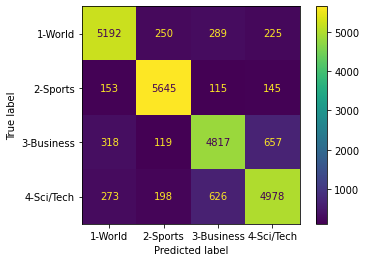

In [146]:
# вывод Confusion Matrix, отражающей качество предсказаний
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Y_test, preds), display_labels = ["1-World", "2-Sports", "3-Business", "4-Sci/Tech"]).plot()
plt.grid(False) # убирание сетки
plt.show() # вывод графика

## 6) Реализация собственной модели

### Создание собственной модели

### Обучение собственной модели

Так как вариантом с лучшими метриками оказался — , то собственная модель будет обучаться на токенах, предобработанных таким же образом.

# Выводы

        Очистку данных стоит проводить хоть какую-нибудь (лучше всего — полную), так как при её отсутствии были получены худшие метрики. 

        Для нормализации токенов лучше всего использовать lemmatization. С ним, в среднем, модели имели больший score.

        В качестве векторизации можно использовать Count Vectorizer, TF-IDF и GloVe (чем больше словарь/размерность вектора — тем качественнее получаются модели, но и обучение их начинает занимать больше времени). Кроме того, в Count Vectorizer и TF-IDF координаты вектора соответствуют реальным токенам. Для использования Word2Vec, возможно, нужно было его больше обучать на корпусе данных.

        Лучшей субъективной комбинацией оказалась: полная очистка текста + лемматизация + glove. (По таблице: очистка только чисел + отсутствие нормализации + glove, однако разница между ними не большая, только начиная с третьего знака после запятой). 

# Всякие тесты (не для проверки)

In [ ]:
data_train["Text"][5]

'Stocks End Up, But Near Year Lows (Reuters). Reuters - Stocks ended slightly higher on Friday\\but stayed near lows for the year as oil prices surged past  #36;46\\a barrel, offsetting a positive outlook from computer maker\\Dell Inc. (DELL.O)'

In [ ]:
sites = {".ru": 0, ".com": 0, ".ua": 0, "@": 0}
for text in pd.concat([data_train["Text"], data_validation["Text"]], ignore_index=True):
    for key in sites.keys():
        if text.find(key) != -1:
            sites[key] += 1
            print(text)
            break

sites

Eye-catching wireless technology (SiliconValley.com). SiliconValley.com - SAN DIEGO - For two days last week, companies from around the globe converged near San Diego to showcase their best products and services using mobile and wireless technology.
Concerns on Cisco bid suppressed (SiliconValley.com). SiliconValley.com - Six months before the San Jose-Cisco Systems controversy went public, Leon Nix knew the city risked violating its own rules by favoring the networking company's products in its new City Hall. But he feared speaking out, thinking his bosses might come after him.
Schools Weather PC Onslaught. Schools across the Washington region relied on stringent new security precautions that helped quarantine infected PCs before they even had a chance to spread their disease. &lt;FONT face="verdana,MS Sans Serif,arial,helvetica" size="-2"\ color="#666666"&gt;&lt;B&gt;-washingtonpost.com&lt;/B&gt;&lt;/FONT&gt;
Kyocera boost to Chinese PAS unit (FT.com). FT.com - Japan's Kyocera is to 

{'.ru': 0, '.com': 3493, '.ua': 0, '@': 0}

In [ ]:
str = "EBay plans to buy the apartment and home \\rental service Rent.com for \$415 million, adding to its already exhaustive breadth of offerings."

EXCLUDE_SYMBOLS_STR = u''.join(['\\', '/', '.', ',', '?', '!', '(', ')', '-', '_', '=', '*', '&', '"', '#', ':', ';', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']) # символы для удаления

regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
str = regex_symb.sub(' ', str)
str = str.strip()
str = str.lower()
str

'ebay plans to buy the apartment and home  rental service rent com for  $    million  adding to its already exhaustive breadth of offerings'